In [ ]:
# this notebook contains Inception V3 for Multi-labelled data oversampled
# Not APTOS

In [1]:
import json
import math
import os
import glob
import re
import cv2

from PIL import Image
import numpy as np
from keras import layers
from keras.applications import InceptionV3
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from sklearn.utils import resample
import tensorflow as tf
from tqdm import tqdm
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

%matplotlib inline

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True 
config.gpu_options.per_process_gpu_memory_fraction = 0.9
sess = tf.Session(config = config)
set_session(sess)

In [3]:
np.random.seed(2019)
tf.set_random_seed(2019)

In [4]:
def preprocess_image(image_path, desired_size=299):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [5]:
def path(_dir, data=None):
    
    base_dir = _dir
    if data == "aptos":
        df = pd.read_csv(base_dir+"train.csv", sep=',')
    else:
        all_files = glob.glob(os.path.join(base_dir, 'train_resized', '*.jpeg'))
        df = pd.read_csv(base_dir+"trainLabels.csv", sep=',')
        all_files_name = [re.sub(r'.*/home/sofosumensah/lustre/PhD/data/train_resized/', '', i) for i in all_files]
        all_files_dict = {"image": all_files_name}
        pd_files = pd.DataFrame.from_dict(all_files_dict)
        pd_files['image'] = pd_files['image'].str.replace(r'.jpeg', '')
        keepImages = list(pd_files['image'])
        df = df[df['image'].isin(keepImages)]
    
    return df

In [6]:
train_df = path('/home/sofosumensah/lustre/PhD/data/')

In [7]:
count_levels = np.bincount(train_df.iloc[:,1].values)
class_weights = dict(enumerate(np.sum(count_levels)/(count_levels * count_levels.size)))

In [8]:
train_df.head()

image  level
0   10_left      0
1  10_right      0
2   13_left      0
3  13_right      0
4   15_left      1

In [9]:
def load_data(labels, data=None, oversample=True, multi_label=True):
        
    if oversample:
        new_df = pd.DataFrame()
        major = labels[labels.iloc[:,1] == np.argmax(np.bincount(labels.iloc[:,1]))]
        minors = np.unique(labels.iloc[:,1])[np.unique(labels.iloc[:,1]) != np.argmax(np.bincount(labels.iloc[:,1]))]
        for i in minors:
            minor = labels[labels.iloc[:,1] == i]
            n = len(major) - len(minor)
            minor_df = resample(minor, replace=True, n_samples=n+len(minor), random_state=42)
            new_df = new_df.append(minor_df)
        new_df = new_df.reset_index(drop=True)
        labels = pd.concat([major, new_df], ignore_index=True)
        labels = labels.reset_index(drop=True)
    else:
        pass
    labels = labels.reset_index(drop=True)
    N = labels.shape[0]
    x_train = np.empty((N, 299, 299, 3), dtype=np.uint8)
    y_train = pd.get_dummies(labels.iloc[:,1]).values
    
    if multi_label:
        y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
        y_train_multi[:, 4] = y_train[:, 4]
        
        for i in range(3, -1, -1):
            y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])
        
        y_train = y_train_multi
    
    for i, image_id in enumerate(tqdm(labels.iloc[:,0])):
        if data == 'aptos':
            x_train[i, :, :, :] = preprocess_image(f'/home/sofosumensah/lustre/PhD/data/Aptos/train_images/{image_id}.png')
        else:
            try:
                x_train[i, :, :, :] = preprocess_image(f'/home/sofosumensah/lustre/PhD/data/train_resized/{image_id}.jpeg')
            except FileNotFoundError:
                continue
                
    return x_train, y_train

In [10]:
x_train, y_train = load_data(train_df, multi_label=True)

100%|██████████| 129000/129000 [37:11<00:00, 57.82it/s] 


In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.15, 
    random_state=2019
)

In [12]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=2019)

In [13]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss
    
    return focal_loss

In [14]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
#         y_val = np.argmax(y_val, axis=1)
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
#         y_pred = np.argmax(y_pred, axis=1)
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model_inceptionv3_odata.h5')

        return

In [15]:
densenet = InceptionV3(
    weights='/home/sofosumensah/lustre/PhD/PyTorch_RAM/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
    include_top=False,
    input_shape=(299,299,3)
)

In [16]:
GAP_layer = layers.GlobalAveragePooling2D()
drop_layer = layers.Dropout(0.5)
dense_layer = layers.Dense(5, activation='sigmoid', name='final_output')

def build_model(loss=None):
    base_model = densenet
    
    x = GAP_layer(base_model.layers[-1].output)
    x = drop_layer(x)
    final_output = dense_layer(x)
    model = Model(base_model.layers[0].input, final_output)
    if loss == 'focal_loss':
        model.compile(loss=categorical_focal_loss(gamma=2.0, alpha=0.25), optimizer=Adam(lr=0.00005), metrics=["accuracy"])
    else:
        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(lr=0.00005),
            metrics=['accuracy']
        )
    
    return model

In [17]:
model = build_model()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    class_weight=class_weights,
    max_queue_size=10, 
    workers=10,
    callbacks=[kappa_metrics]
)


Epoch 1/15
3427/3426 [==============================] - 1110s 324ms/step - loss: 0.0573 - accuracy: 0.9042 - val_loss: 0.1350 - val_accuracy: 0.9389
val_kappa: 0.9049
Validation Kappa has improved. Saving model.
Epoch 2/15
3427/3426 [==============================] - 1360s 397ms/step - loss: 0.0346 - accuracy: 0.9430 - val_loss: 0.1070 - val_accuracy: 0.9521
val_kappa: 0.9261
Validation Kappa has improved. Saving model.
Epoch 3/15
3427/3426 [==============================] - 1073s 313ms/step - loss: 0.0258 - accuracy: 0.9592 - val_loss: 0.0901 - val_accuracy: 0.9625
val_kappa: 0.9370
Validation Kappa has improved. Saving model.
Epoch 4/15
3427/3426 [==============================] - 1110s 324ms/step - loss: 0.0197 - accuracy: 0.9704 - val_loss: 0.0711 - val_accuracy: 0.9724
val_kappa: 0.9487
Validation Kappa has improved. Saving model.
Epoch 5/15
3427/3426 [==============================] - 1167s 340ms/step - loss: 0.0151 - accuracy: 0.9779 - val_loss: 0.0606 - val_accuracy: 0.9778
va

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3426/3426 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.9916

In [21]:
model.load_weights('model_inceptionv3_odata.h5')

In [22]:
test_df = pd.read_csv("/home/sofosumensah/lustre/PhD/data/retinopathy_solution.csv", sep=',')

In [26]:
N = test_df.shape[0]
x_test = np.empty((N, 299, 299, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(test_df.iloc[:, 0])):
    x_test[i, :, :, :] = preprocess_image(
        f'/home/sofosumensah/lustre/PhD/data/test_resized/{image_id}.jpeg'
    )

  8%|▊         | 4204/53576 [03:21<39:21, 20.91it/s]  


FileNotFoundError: [Errno 2] No such file or directory: '/home/sofosumensah/lustre/PhD/data/test_resized/3517_left.jpeg'

In [23]:
def load_image_ben_orig(path, resize=True, crop=False, norm255=True, keras=False):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0) , 10), -4, 128)
    if norm255:
        return image/255
    elif keras:
        image = np.expand_dims(image, axis=0)
        return preprocess_input(image)[0]
    else:
        return image.astype(np.int16)
    
    return image

In [24]:
def show_image(image, figsize=None, title=None):
    
    if figsize is not None:
        fig = plt.figure(figsize=figsize)
        
    if image.ndim == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
        
    if title is not None:
        plt.title(title)

def show_Nimages(imgs, scale=1):

    N = len(imgs)
    fig = plt.figure(figsize=(25/scale, 16/scale))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1, N, i + 1, xticks=[], yticks=[])
        show_image(img)
        
def print_pred(array_of_classes):
    xx = array_of_classes
    s1,s2 = xx.shape
    for i in range(s1):
        for j in range(s2):
            print('%.3f ' % xx[i,j],end='')
        print('')

In [25]:
def gen_heatmap_img(img, model0, layer_name='last_conv_layer',viz_img=None,orig_img=None):
    preds_raw = model0.predict(img[np.newaxis])
    preds = preds_raw > 0.5 
    class_idx = (preds.astype(int).sum(axis=1) - 1)[0]
    class_output_tensor = model0.output[:, class_idx]
    
    viz_layer = model0.get_layer(layer_name)
    grads = K.gradients(
                        class_output_tensor ,
                        viz_layer.output
                        )[0] 
    
    pooled_grads=K.mean(grads,axis=(0,1,2))
    iterate=K.function([model0.input],[pooled_grads, viz_layer.output[0]])
    
    pooled_grad_value, viz_layer_out_value = iterate([img[np.newaxis]])
    
    for i in range(pooled_grad_value.shape[0]):
        viz_layer_out_value[:,:,i] *= pooled_grad_value[i]
    
    heatmap = np.mean(viz_layer_out_value, axis=-1)
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)

    viz_img=cv2.resize(viz_img,(img.shape[1],img.shape[0]))
    heatmap=cv2.resize(heatmap,(viz_img.shape[1],viz_img.shape[0]))
    
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap*255), cv2.COLORMAP_SPRING)/255
    heated_img = heatmap_color*0.5 + viz_img*0.5
    
    print('raw output from model : ')
    print_pred(preds_raw)
    
    if orig_img is None:
        show_Nimages([img,viz_img,heatmap_color,heated_img])
    else:
        show_Nimages([orig_img,img,viz_img,heatmap_color,heated_img])
    
    plt.show()
    return heated_img

test pic no.1
raw output from model : 
1.000 0.799 0.000 0.000 0.000 


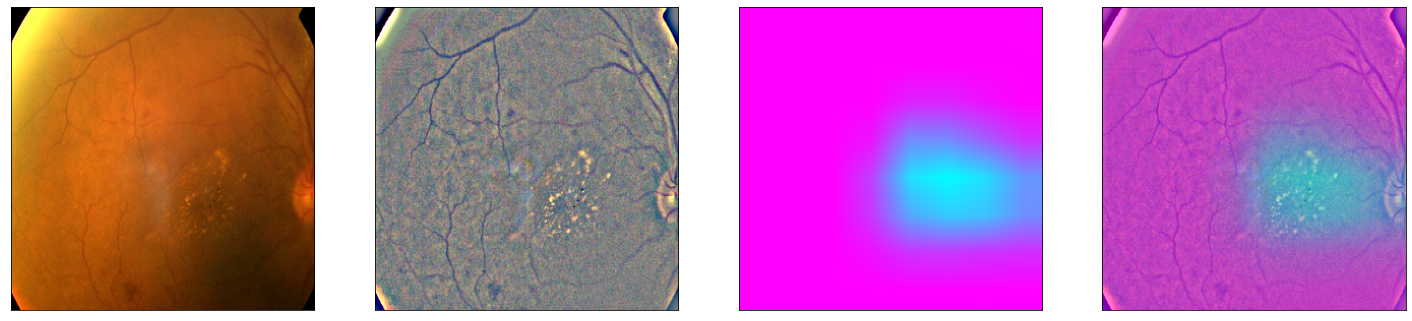

test pic no.2
raw output from model : 
1.000 0.999 0.992 0.566 0.002 


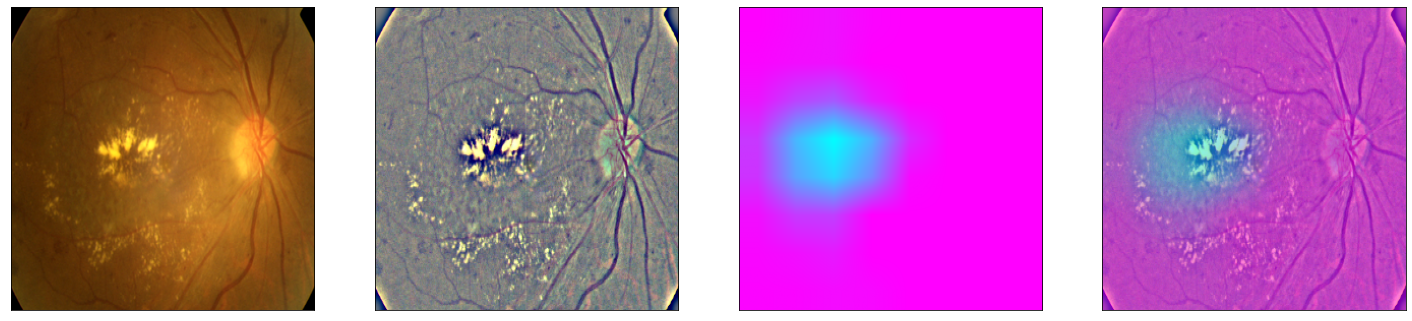

test pic no.3
raw output from model : 
1.000 1.000 1.000 0.162 0.050 


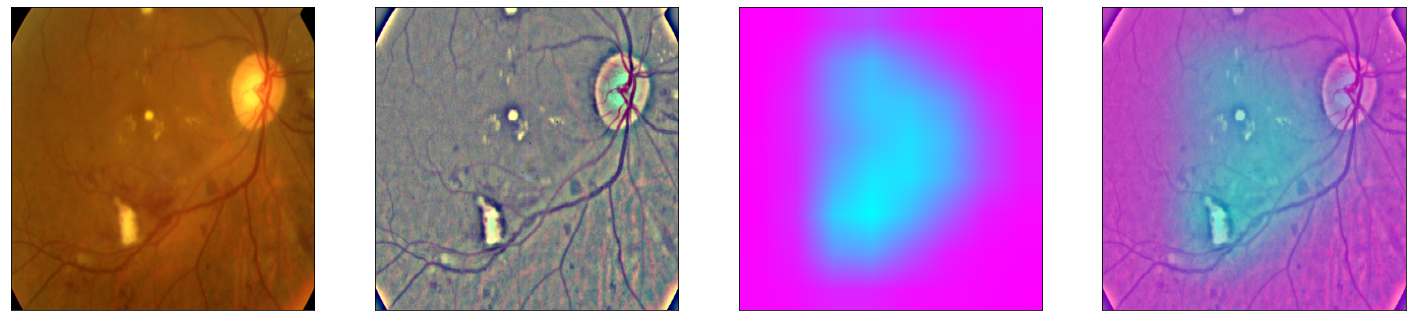

test pic no.4
raw output from model : 
1.000 1.000 0.946 0.000 0.000 


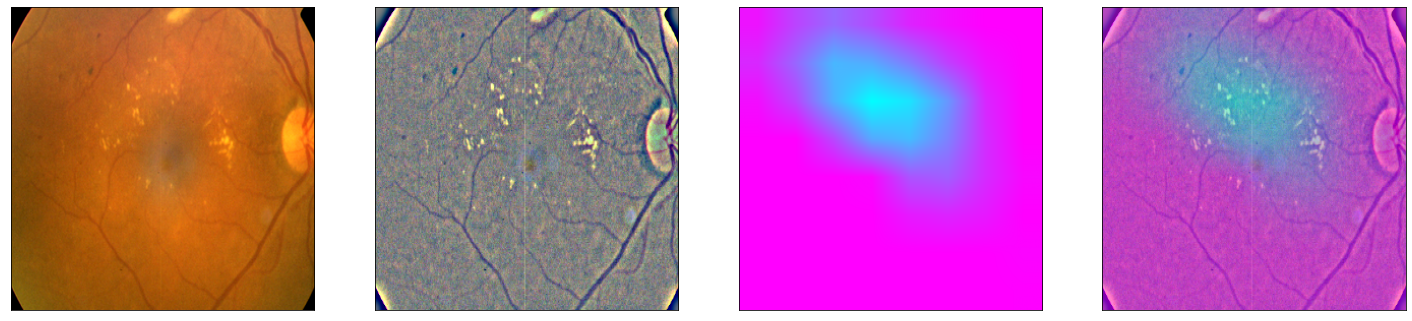

test pic no.5
raw output from model : 
0.999 0.986 0.504 0.127 0.016 


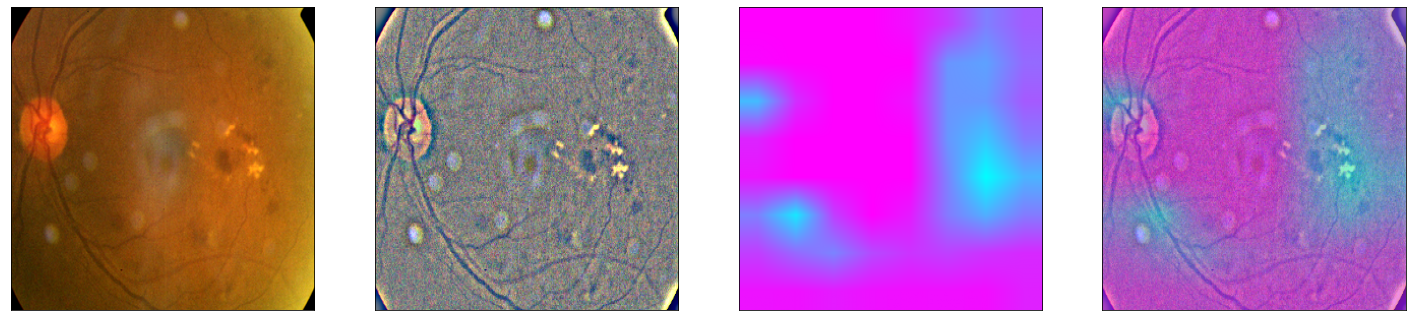

test pic no.6
raw output from model : 
0.999 0.997 0.984 0.004 0.003 


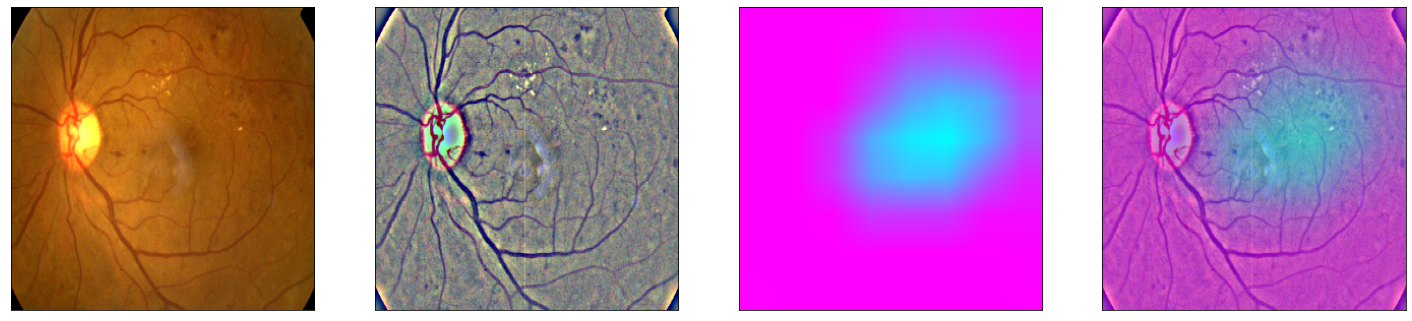

test pic no.7
raw output from model : 
1.000 1.000 0.999 0.851 0.000 


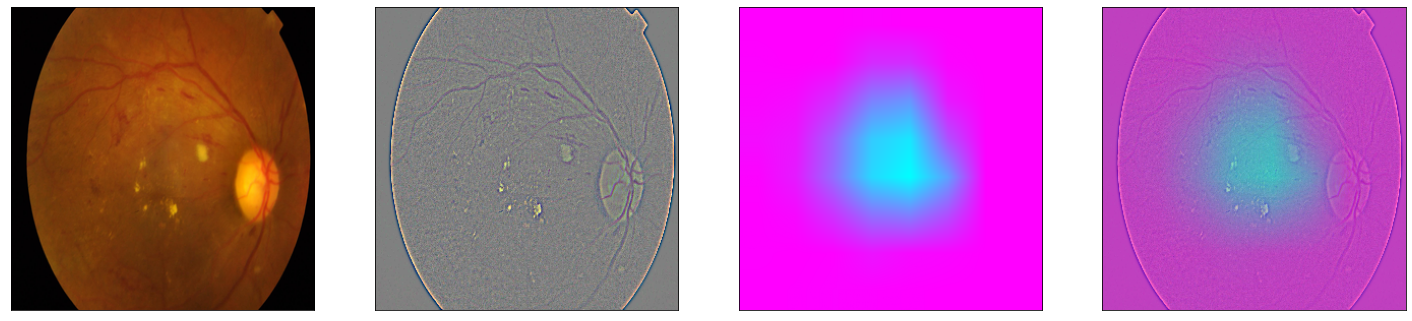

test pic no.8
raw output from model : 
1.000 1.000 0.000 0.000 0.000 


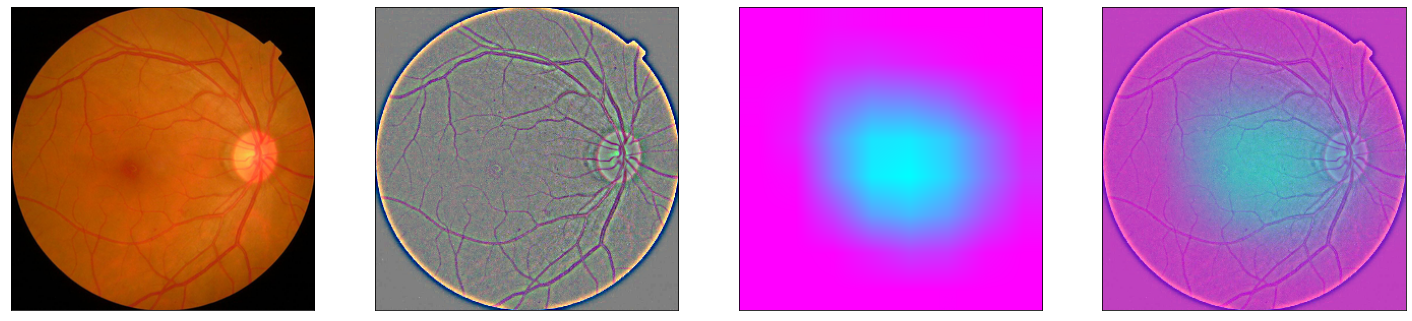

test pic no.9
raw output from model : 
1.000 1.000 1.000 0.419 0.022 


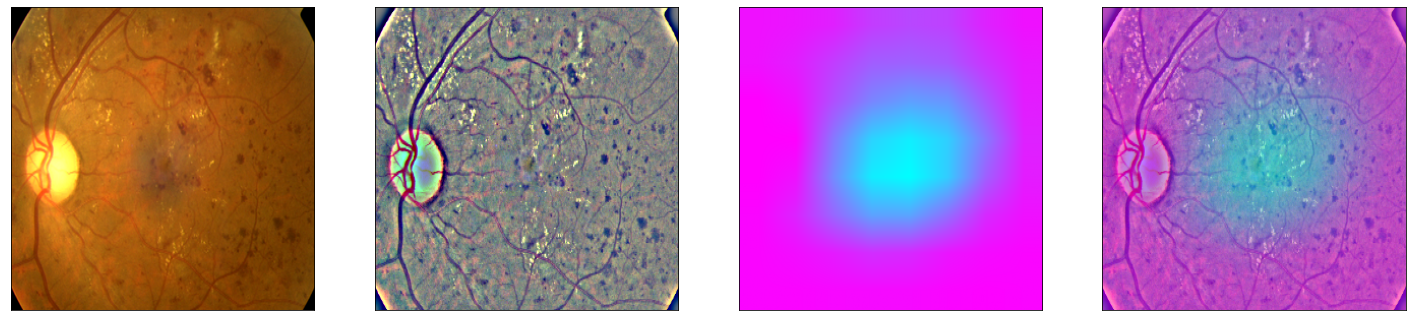

test pic no.10
raw output from model : 
1.000 0.400 0.000 0.000 0.000 


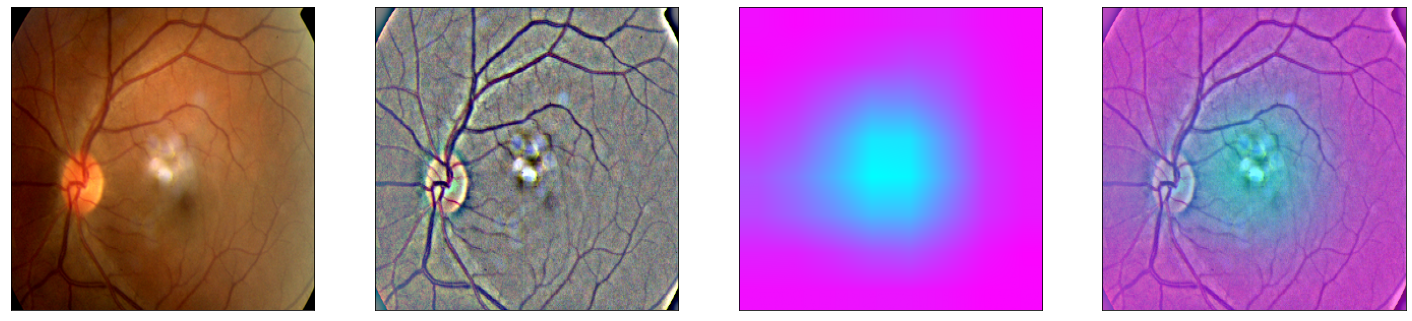

In [26]:
NUM_SAMP=10
SEED=77
layer_name = 'mixed10' #'conv5_block16_concat'
for i, (idx, row) in enumerate(test_df[:NUM_SAMP].iterrows()):
    path=f"/home/sofosumensah/lustre/PhD/data/Aptos/test_images/{row['id_code']}.png"
    ben_img = load_image_ben_orig(path)
    input_img = np.empty((1,299, 299, 3), dtype=np.uint8)
    input_img[0,:,:,:] = preprocess_image(path)
        
    print('test pic no.%d' % (i+1))
    _ = gen_heatmap_img(input_img[0],
                        model, 
                        layer_name=layer_name, 
                        viz_img=ben_img)